# 🔐 Data Against Misrepresentation — Offline Analysis Notebook

This notebook analyses `media_articles_guardian_2020_2025.csv` **offline** using NLTK VADER and TextBlob.

### What it does
1. Loads your CSV
2. Cleans text
3. Computes sentiment (headline & body)
4. Aggregates by faith group and over time
5. Extracts top TF‑IDF keywords (headlines)
6. Exports CSV summaries and renders Matplotlib charts

> Notes: No external APIs. Only local libraries.


In [2]:
# --- Setup / Installs (run first) ---
!pip install pandas numpy matplotlib nltk textblob scikit-learn --quiet

import pandas as pd, numpy as np
import re, math
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK data (first run only)
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

print('Setup complete')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Setup complete


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# --- Load dataset (robust) ---
import csv, io

CSV_PATH = 'media_articles_guardian_2020_2025.csv'  # adjust if needed

# Try fast C engine first; if it fails, fall back to python engine + on_bad_lines='skip'
try:
    df = pd.read_csv(CSV_PATH, encoding='utf-8')
except Exception as e:
    print("C engine failed -> switching to python engine with safe options.\nReason:", e)
    df = pd.read_csv(
        CSV_PATH,
        encoding='utf-8',
        engine='python',        # more forgiving parser
        on_bad_lines='skip',    # skip malformed rows
        quoting=csv.QUOTE_MINIMAL
    )

# Basic checks/clean-up
expected_cols = {'source','title','content','date','url','faith_group','keywords_detected'}
missing = expected_cols - set(df.columns)
print('Rows loaded:', len(df))
print('Missing expected columns:', missing)

# Clean types
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['title','content','date']).reset_index(drop=True)
print('Rows after cleaning:', len(df))
df.head(3)

Rows loaded: 29311
Missing expected columns: set()
Rows after cleaning: 29303


,source,title,content,date,url,faith_group,keywords_detected
0,The Guardian,Anti- and pro-Brexit campaign heads join open ...,The former directors of both the leave and rem...,2020-01-01 00:01:49+00:00,https://www.theguardian.com/politics/2020/jan/...,jewish,jew;jewish
1,The Guardian,"Let's resolve to reconnect, says Welby in new ...",The archbishop of Canterbury will urge people ...,2020-01-01 00:01:49+00:00,https://www.theguardian.com/uk-news/2020/jan/0...,christian,archbishop;bible;christian;church
2,The Guardian,Messiah review – it's Homeland ... with a divi...,Is he the messiah? Or is he a very naughty boy...,2020-01-01 06:00:56+00:00,https://www.theguardian.com/tv-and-radio/2020/...,christian,church;priest


In [5]:
# --- Basic EDA ---
print('Articles per faith_group:')
print(df['faith_group'].value_counts())
print('\nDate range:', df['date'].min(), '→', df['date'].max())


Articles per faith_group:
faith_group
muslim       12496
christian     9091
jewish        7716
Name: count, dtype: int64

Date range: 2020-01-01 00:01:49+00:00 → 2025-10-19 08:00:08+00:00


In [6]:
# --- Preprocess text (lightweight) ---
from nltk.corpus import stopwords
STOP = set(stopwords.words('english'))
EXTRA_STOP = set(['said','news','guardian','uk','britain','british'])
STOP |= EXTRA_STOP

def clean_text(s: str) -> str:
    import re
    s = str(s).lower()
    s = re.sub(r"\s+", ' ', s)
    return s.strip()

df['title_clean'] = df['title'].astype(str).map(clean_text)
df['content_clean'] = df['content'].astype(str).map(clean_text)
print('Preprocessing done')


Preprocessing done


In [8]:
# --- Faster Sentiment: VADER + PatternAnalyzer (TextBlob) ---

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Use TextBlob's fast PatternAnalyzer directly (avoids heavy TextBlob objects)
try:
    from textblob.sentiments import PatternAnalyzer
    blob = PatternAnalyzer()
    use_blob = True
except Exception:
    # Fallback: skip blob if Pattern not available
    use_blob = False

# Prepare text (avoid try/except inside tight loops)
titles = df['title_clean'].fillna('').astype(str).tolist()
# Truncate bodies to speed up (adjust 1000 if you like)
bodies = [str(x)[:1000] if x is not None else '' for x in df['content_clean']]

# VADER (fast, single analyzer reused)
sent_head_vader = [sia.polarity_scores(t)['compound'] for t in titles]
sent_body_vader = [sia.polarity_scores(t)['compound'] for t in bodies]

# PatternAnalyzer polarity (much faster than TextBlob(text).sentiment)
if use_blob:
    sent_head_blob = [blob.analyze(t).polarity for t in titles]
    sent_body_blob = [blob.analyze(t).polarity for t in bodies]
else:
    import numpy as np
    sent_head_blob = [np.nan] * len(titles)
    sent_body_blob = [np.nan] * len(bodies)

# Assign back in one go
df['sent_head_vader'] = sent_head_vader
df['sent_body_vader'] = sent_body_vader
df['sent_head_blob']  = sent_head_blob
df['sent_body_blob']  = sent_body_blob

# Combined scores (rowwise mean of available)
df['sent_head_combined'] = df[['sent_head_vader','sent_head_blob']].mean(axis=1, skipna=True)
df['sent_body_combined'] = df[['sent_body_vader','sent_body_blob']].mean(axis=1, skipna=True)

print('Sentiment computed')
display(df[['sent_head_vader','sent_body_vader','sent_head_blob','sent_body_blob']].describe())


Sentiment computed


,sent_head_vader,sent_body_vader,sent_head_blob,sent_body_blob
count,29303.000000,29303.000000,29303.000000,29303.000000
mean,-0.106807,-0.088776,0.034602,0.067672
std,0.424566,0.789239,0.257182,0.107208
min,-0.966100,-0.998600,-1.000000,-0.600000
25%,-0.458800,-0.904400,0.000000,0.000645
50%,0.000000,-0.273200,0.000000,0.066964
75%,0.077200,0.800900,0.090909,0.135539
max,0.946000,0.998500,1.000000,0.672727


In [9]:
# --- Aggregations by faith_group and by month ---
grp = df.groupby('faith_group', as_index=False).agg(
    n_articles=('url','count'),
    head_mean=('sent_head_combined','mean'),
    body_mean=('sent_body_combined','mean')
)
grp = grp.sort_values('n_articles', ascending=False)
print('By faith_group:')
print(grp)

df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
monthly = df.groupby(['faith_group','month'], as_index=False).agg(
    n=('url','count'),
    head_mean=('sent_head_combined','mean'),
    body_mean=('sent_body_combined','mean')
)
print('Monthly rows:', len(monthly))

# Save summaries
grp.to_csv('guardian_group_summary.csv', index=False)
monthly.to_csv('guardian_monthly_summary.csv', index=False)
df[['source','title','date','url','faith_group','sent_head_combined','sent_body_combined']].to_csv('guardian_article_sentiment.csv', index=False)
print('Saved: guardian_group_summary.csv, guardian_monthly_summary.csv, guardian_article_sentiment.csv')


By faith_group:
  faith_group  n_articles  head_mean  body_mean
2      muslim       12496  -0.072472  -0.086928
0   christian        9091  -0.000018   0.081640
1      jewish        7716  -0.019716   0.004518
Monthly rows: 199


/tmp/ipython-input-3192084753.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()


Saved: guardian_group_summary.csv, guardian_monthly_summary.csv, guardian_article_sentiment.csv


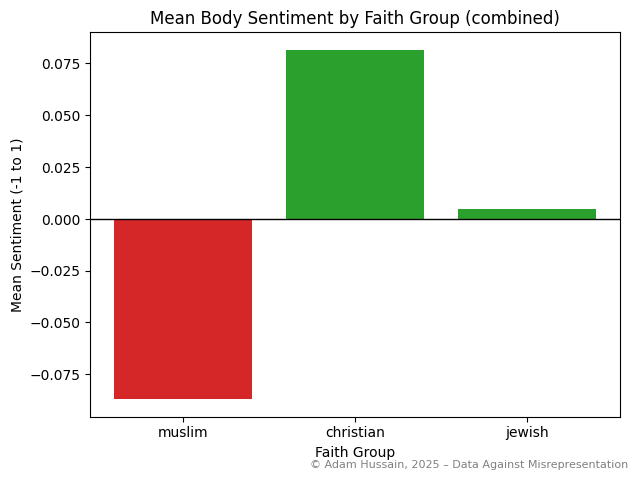

In [22]:
# --- Chart 1: Mean body sentiment by faith_group ---
colors = ['#d62728' if v < 0 else '#2ca02c' for v in grp['body_mean']]
plt.figure()
ax = plt.gca()
ax.bar(grp['faith_group'], grp['body_mean'], color=colors)
ax.axhline(0, color='black', linewidth=1)
ax.set_title('Mean Body Sentiment by Faith Group (combined)')
ax.set_xlabel('Faith Group'); ax.set_ylabel('Mean Sentiment (-1 to 1)')
plt.tight_layout()
plt.figtext(0.99, 0.01, "© Adam Hussain, 2025 – Data Against Misrepresentation",
            ha='right', va='bottom', fontsize=8, color='gray')
plt.show()

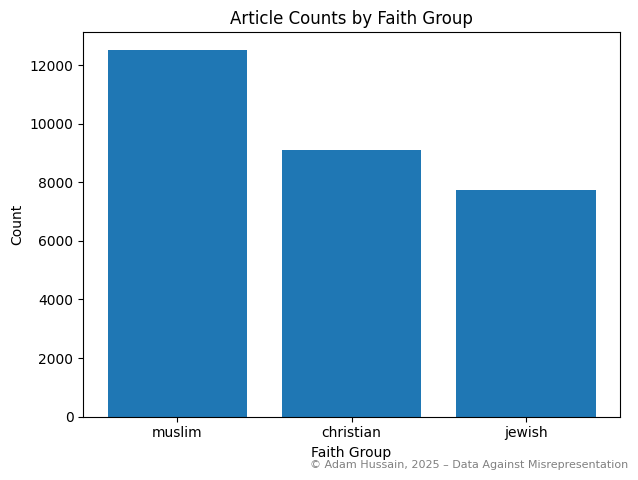

In [23]:
# --- Chart 2: Articles count by faith_group ---
plt.figure()
ax = plt.gca()
ax.bar(grp['faith_group'], grp['n_articles'])
ax.set_title('Article Counts by Faith Group')
ax.set_xlabel('Faith Group'); ax.set_ylabel('Count')
plt.tight_layout()
plt.figtext(0.99, 0.01, "© Adam Hussain, 2025 – Data Against Misrepresentation",
            ha='right', va='bottom', fontsize=8, color='gray')
plt.show()


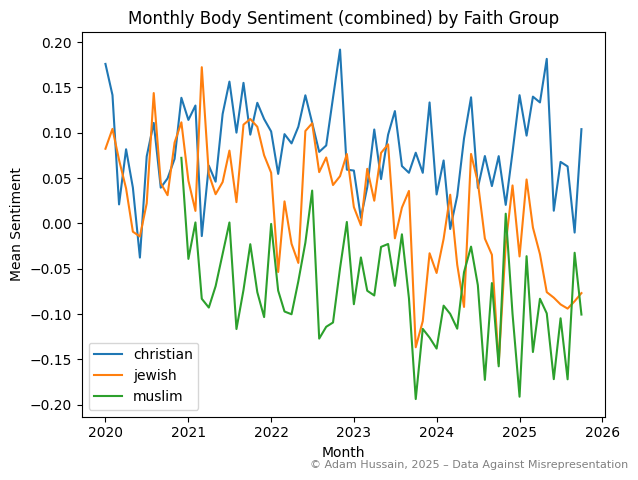

In [24]:
# --- Chart 3: Monthly body sentiment trend per faith_group ---
plt.figure()
ax = plt.gca()
for fg, sub in monthly.groupby('faith_group'):
    ax.plot(sub['month'], sub['body_mean'], label=str(fg))
ax.set_title('Monthly Body Sentiment (combined) by Faith Group')
ax.set_xlabel('Month'); ax.set_ylabel('Mean Sentiment')
ax.legend()
plt.tight_layout()
plt.figtext(0.99, 0.01, "© Adam Hussain, 2025 – Data Against Misrepresentation",
            ha='right', va='bottom', fontsize=8, color='gray')
plt.show()


In [13]:
# --- TF-IDF top headline terms per faith_group ---
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def top_tfidf_terms(texts, n=25):
    if len(texts) == 0:
        return []
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2), min_df=3)
    X = vectorizer.fit_transform(texts)
    means = np.asarray(X.mean(axis=0)).ravel()
    vocab = np.array(vectorizer.get_feature_names_out())
    idx = np.argsort(-means)[:n]
    return list(zip(vocab[idx], means[idx]))

rows = []
for fg, sub in df.groupby('faith_group'):
    terms = top_tfidf_terms(sub['title_clean'].tolist(), n=30)
    for rank, (term, score) in enumerate(terms, start=1):
        rows.append({'faith_group': fg, 'rank': rank, 'term': term, 'score': float(score)})

tfidf_headlines = pd.DataFrame(rows)
tfidf_headlines.to_csv('guardian_tfidf_headlines.csv', index=False)
print('Saved: guardian_tfidf_headlines.csv')
tfidf_headlines.head(10)


Saved: guardian_tfidf_headlines.csv


,faith_group,rank,term,score
0,christian,1,review,0.018861
1,christian,2,obituary,0.017610
2,christian,3,church,0.013572
3,christian,4,happened,0.012642
4,christian,5,christian,0.011189
5,christian,6,trump,0.009234
6,christian,7,new,0.009094
7,christian,8,says,0.008335
8,christian,9,uk,0.007243
9,christian,10,covid,0.006189


In [14]:
# --- Executive summary text block ---
summary_lines = []
summary_lines.append(f"Dataset size: {len(df):,} articles from The Guardian (2020→{df['date'].max().year}).")
for _, r in grp.iterrows():
    summary_lines.append(f"- {r['faith_group'].title()}: n={int(r['n_articles'])}, mean headline sentiment={r['head_mean']:.3f}, mean body sentiment={r['body_mean']:.3f}")
with open('guardian_exec_summary.txt','w') as f:
    f.write('\n'.join(summary_lines))
print('\n'.join(summary_lines))
print('\nSaved: guardian_exec_summary.txt')


Dataset size: 29,303 articles from The Guardian (2020→2025).
- Muslim: n=12496, mean headline sentiment=-0.072, mean body sentiment=-0.087
- Christian: n=9091, mean headline sentiment=-0.000, mean body sentiment=0.082
- Jewish: n=7716, mean headline sentiment=-0.020, mean body sentiment=0.005

Saved: guardian_exec_summary.txt
